### Imports and paths

In [1]:
# !pip install tflite_runtime
# !pip install opencv-python
# !pip install mediapipe
# !sudo apt-get install ffmpeg

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import mediapipe as mp

import tflite_runtime

from pathlib import Path

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic


from IPython.display import Image, display, Video


In [3]:
DATA_DIR         = Path('../raw_data/google')
TRAIN_CSV_PATH   = DATA_DIR/'train.csv'
LANDMARK_DIR     = DATA_DIR/'train_landmark_files'
LABEL_MAP_PATH   = DATA_DIR/'sign_to_prediction_index_map.json'

WLASL_DIR = Path('../raw_data/WLASL_processed')
WLASL_JSON_PATH = WLASL_DIR/'WLASL_v0.3.json'
WLASL_VIDEO_DIR = WLASL_DIR/'videos'

In [4]:
!tree -L 3 ..

..
├── Makefile
├── notebooks
│   └── notebook_exploratory_data_analaysis_benoitfrisque.ipynb
├── raw_data
│   ├── google
│   │   ├── sign_to_prediction_index_map.json
│   │   ├── train.csv
│   │   └── train_landmark_files
│   ├── WLASL_original
│   │   ├── code
│   │   ├── _config.yml
│   │   ├── index.md
│   │   ├── README.md
│   │   └── start_kit
│   └── WLASL_processed
│       ├── missing.txt
│       ├── nslt_1000.json
│       ├── nslt_100.json
│       ├── nslt_2000.json
│       ├── nslt_300.json
│       ├── videos
│       ├── wlasl_class_list.txt
│       └── WLASL_v0.3.json
├── README.md
└── requirements.txt

9 directories, 16 files


# Google Data

### Data description

**Files**

**train_landmark_files/[participant_id]/[sequence_id].parquet** The landmark data. The landmarks were extracted from raw videos with the MediaPipe holistic model. Not all of the frames necessarily had visible hands or hands that could be detected by the model.

Landmark data should not be used to identify or re-identify an individual. Landmark data is not intended to enable any form of identity recognition or store any unique biometric identification.

- `frame` - The frame number in the raw video.
- `row_id` - A unique identifier for the row.
- `type` - The type of landmark. One of ['face', 'left_hand', 'pose', 'right_hand'].
- `landmark_index` - The landmark index number. Details of the hand landmark locations can be found here.
- `[x/y/z]` - The normalized spatial coordinates of the landmark. These are the only columns that will be provided to your submitted model for inference. The MediaPipe model is not fully trained to predict depth so you may wish to ignore the z values.

**train.csv**

- `path` - The path to the landmark file.
- `participant_id` - A unique identifier for the data contributor.
- `sequence_id` - A unique identifier for the landmark sequence.
- `sign` - The label for the landmark sequence.

### Data preview

In [5]:
train = pd.read_csv(TRAIN_CSV_PATH)
train

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie
...,...,...,...,...
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room


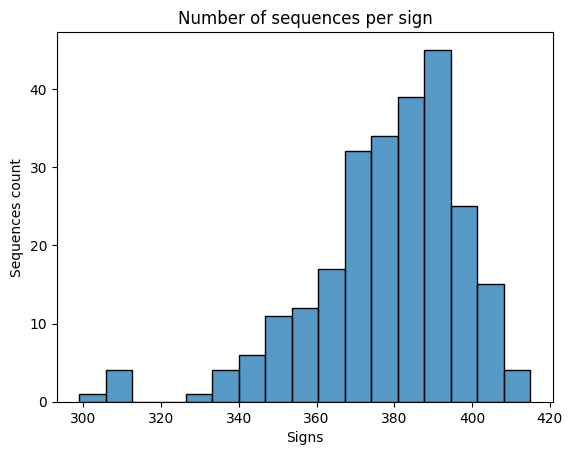

In [6]:
sns.histplot(train[['sign']].value_counts())
plt.title('Number of sequences per sign')
plt.xlabel('Signs')
plt.ylabel('Sequences count');

In [7]:
train['file_path'] = str(DATA_DIR) + '/' + train['path']

In [8]:
train.loc[0, "file_path"]

'../raw_data/google/train_landmark_files/26734/1000035562.parquet'

In [9]:
data = pd.read_parquet(train.loc[0, "file_path"])
data

,frame,row_id,type,landmark_index,x,y,z
0,20,20-face-0,face,0,0.494400,0.380470,-0.030626
1,20,20-face-1,face,1,0.496017,0.350735,-0.057565
2,20,20-face-2,face,2,0.500818,0.359343,-0.030283
3,20,20-face-3,face,3,0.489788,0.321780,-0.040622
4,20,20-face-4,face,4,0.495304,0.341821,-0.061152
...,...,...,...,...,...,...,...
12484,42,42-right_hand-16,right_hand,16,0.001660,0.549574,-0.145409
12485,42,42-right_hand-17,right_hand,17,0.042694,0.693116,-0.085307
12486,42,42-right_hand-18,right_hand,18,0.006723,0.665044,-0.114017
12487,42,42-right_hand-19,right_hand,19,-0.014755,0.643799,-0.123488


In [10]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
ROWS_PER_FRAME = 543  

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [11]:
data_clean = load_relevant_data_subset(train.loc[0, "file_path"])
data_clean

array([[[ 0.49440014,  0.38046983, -0.03062646],
        [ 0.49601725,  0.3507348 , -0.05756483],
        [ 0.5008185 ,  0.35934305, -0.03028346],
        ...,
        [ 0.31373617,  0.41234398, -0.05269891],
        [ 0.35072815,  0.39958185, -0.06021732],
        [ 0.38579622,  0.4011007 , -0.06471767]],

       [[ 0.5011503 ,  0.38055426, -0.03156953],
        [ 0.49290648,  0.3493601 , -0.05817606],
        [ 0.49832708,  0.3581275 , -0.03118932],
        ...,
        [ 0.33588555,  0.3889878 , -0.0631762 ],
        [ 0.37742943,  0.3802519 , -0.07176355],
        [ 0.41639116,  0.38289747, -0.076529  ]],

       [[ 0.49847096,  0.37949273, -0.0309729 ],
        [ 0.49176967,  0.34847346, -0.05721497],
        [ 0.49767977,  0.3573629 , -0.03084622],
        ...,
        [ 0.35855788,  0.3844513 , -0.06097187],
        [ 0.4005313 ,  0.37769613, -0.07045607],
        [ 0.43907768,  0.37987   , -0.07860945]],

       ...,

       [[ 0.5357876 ,  0.37571952, -0.04070858],
        [ 0

In [12]:
data_clean = load_relevant_data_subset(train.loc[0, "file_path"])
data_clean.shape # number of frames, number of landmarks, # coordinates (x, y, z)

(23, 543, 3)

### Labels

In [13]:
labels_df = pd.read_json(LABEL_MAP_PATH, orient='index').reset_index().set_index(0).rename(columns={'index':'sign'})
labels_df.index.rename('index', inplace=True)
labels_df

,sign
index,
0,TV
1,after
2,airplane
3,all
4,alligator
...,...
245,yesterday
246,yourself
247,yucky


In [14]:
# # Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
# import tflite_runtime.interpreter as tflite
# interpreter = tflite.Interpreter(model_path)

# found_signatures = list(interpreter.get_signature_list().keys())

# if REQUIRED_SIGNATURE not in found_signatures:
#     raise KernelEvalException('Required input signature not found.')

# prediction_fn = interpreter.get_signature_runner("serving_default")
# output = prediction_fn(inputs=frames)
# sign = np.argmax(output["outputs"])


### Landmarks visualization (animation)

In [15]:
def get_hand_points(hand):
    x = [[hand.iloc[0].x, hand.iloc[1].x, hand.iloc[2].x, hand.iloc[3].x, hand.iloc[4].x], # Thumb
         [hand.iloc[5].x, hand.iloc[6].x, hand.iloc[7].x, hand.iloc[8].x], # Index
         [hand.iloc[9].x, hand.iloc[10].x, hand.iloc[11].x, hand.iloc[12].x], 
         [hand.iloc[13].x, hand.iloc[14].x, hand.iloc[15].x, hand.iloc[16].x], 
         [hand.iloc[17].x, hand.iloc[18].x, hand.iloc[19].x, hand.iloc[20].x], 
         [hand.iloc[0].x, hand.iloc[5].x, hand.iloc[9].x, hand.iloc[13].x, hand.iloc[17].x, hand.iloc[0].x]]

    y = [[hand.iloc[0].y, hand.iloc[1].y, hand.iloc[2].y, hand.iloc[3].y, hand.iloc[4].y],  #Thumb
         [hand.iloc[5].y, hand.iloc[6].y, hand.iloc[7].y, hand.iloc[8].y], # Index
         [hand.iloc[9].y, hand.iloc[10].y, hand.iloc[11].y, hand.iloc[12].y], 
         [hand.iloc[13].y, hand.iloc[14].y, hand.iloc[15].y, hand.iloc[16].y], 
         [hand.iloc[17].y, hand.iloc[18].y, hand.iloc[19].y, hand.iloc[20].y], 
         [hand.iloc[0].y, hand.iloc[5].y, hand.iloc[9].y, hand.iloc[13].y, hand.iloc[17].y, hand.iloc[0].y]] 
    
    return x, y

def get_pose_points(pose):
    x = [[pose.iloc[8].x, pose.iloc[6].x, pose.iloc[5].x, pose.iloc[4].x, pose.iloc[0].x, pose.iloc[1].x, pose.iloc[2].x, pose.iloc[3].x, pose.iloc[7].x], 
         [pose.iloc[10].x, pose.iloc[9].x], 
         [pose.iloc[22].x, pose.iloc[16].x, pose.iloc[20].x, pose.iloc[18].x, pose.iloc[16].x, pose.iloc[14].x, pose.iloc[12].x, 
          pose.iloc[11].x, pose.iloc[13].x, pose.iloc[15].x, pose.iloc[17].x, pose.iloc[19].x, pose.iloc[15].x, pose.iloc[21].x], 
         [pose.iloc[12].x, pose.iloc[24].x, pose.iloc[26].x, pose.iloc[28].x, pose.iloc[30].x, pose.iloc[32].x, pose.iloc[28].x], 
         [pose.iloc[11].x, pose.iloc[23].x, pose.iloc[25].x, pose.iloc[27].x, pose.iloc[29].x, pose.iloc[31].x, pose.iloc[27].x], 
         [pose.iloc[24].x, pose.iloc[23].x]
        ]

    y = [[pose.iloc[8].y, pose.iloc[6].y, pose.iloc[5].y, pose.iloc[4].y, pose.iloc[0].y, pose.iloc[1].y, pose.iloc[2].y, pose.iloc[3].y, pose.iloc[7].y], 
         [pose.iloc[10].y, pose.iloc[9].y], 
         [pose.iloc[22].y, pose.iloc[16].y, pose.iloc[20].y, pose.iloc[18].y, pose.iloc[16].y, pose.iloc[14].y, pose.iloc[12].y, 
          pose.iloc[11].y, pose.iloc[13].y, pose.iloc[15].y, pose.iloc[17].y, pose.iloc[19].y, pose.iloc[15].y, pose.iloc[21].y], 
         [pose.iloc[12].y, pose.iloc[24].y, pose.iloc[26].y, pose.iloc[28].y, pose.iloc[30].y, pose.iloc[32].y, pose.iloc[28].y], 
         [pose.iloc[11].y, pose.iloc[23].y, pose.iloc[25].y, pose.iloc[27].y, pose.iloc[29].y, pose.iloc[31].y, pose.iloc[27].y], 
         [pose.iloc[24].y, pose.iloc[23].y]
        ]
    
    return x, y

In [16]:
sign = data
sign.y = sign.y * -1 # reverse vertically

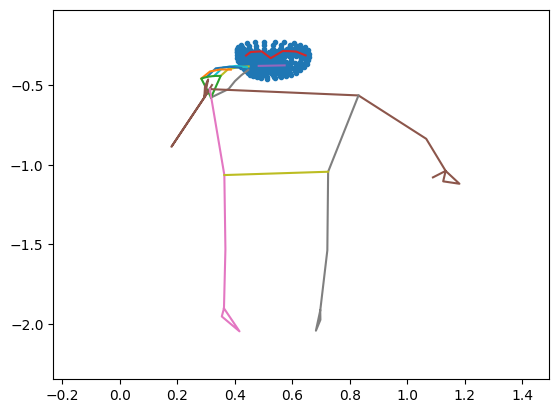

In [17]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animation_frame(f):
    frame = sign[sign.frame==f]
    left = frame[frame.type=='left_hand']
    right = frame[frame.type=='right_hand']
    pose = frame[frame.type=='pose']
    face = frame[frame.type=='face'][['x', 'y']].values
    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)
    ax.clear()
    ax.plot(face[:,0], face[:,1], '.')
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i])
    for i in range(len(px)):
        ax.plot(px[i], py[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
        
## These values set the limits on the graph to stabilize the video
xmin = sign.x.min() - 0.2
xmax = sign.x.max() + 0.2
ymin = sign.y.min() - 0.2
ymax = sign.y.max() + 0.2

fig, ax = plt.subplots(1)
l, = ax.plot([], [])
animation = FuncAnimation(fig,
                          func=animation_frame, frames=sign.frame.unique())

HTML(animation.to_html5_video())

# WLASL Data

## Data description

Data source: https://www.kaggle.com/datasets/risangbaskoro/wlasl-processed/data (originally from https://github.com/dxli94/WLASL?tab=readme-ov-file)

### File Description
-----------------
The repository contains following files:

 * `WLASL_vx.x.json`: JSON file including all the data samples.

 * `data_reader.py`: Sample code for loading the dataset.

 * `video_downloader.py`: Sample code demonstrating how to download data samples.

 * `C-UDA-1.0.pdf`: the Computational Use of Data Agreement (C-UDA) agreement. You must read and agree with the terms before using the dataset.

### Data Description
-----------------

* `gloss`: *str*, data file is structured/categorised based on sign gloss, or namely, labels.

* `bbox`: *[int]*, bounding box detected using YOLOv3 of (xmin, ymin, xmax, ymax) convention. Following OpenCV convention, (0, 0) is the up-left corner.

* `fps`: *int*, frame rate (=25) used to decode the video as in the paper.

* `frame_start`: *int*, the starting frame of the gloss in the video (decoding
with FPS=25), *indexed from 1*.

* `frame_end`: *int*, the ending frame of the gloss in the video (decoding with FPS=25). -1 indicates the gloss ends at the last frame of the video.

* `instance_id`: *int*, id of the instance in the same class/gloss.

* `signer_id`: *int*, id of the signer.

* `source`: *str*, a string identifier for the source site.

* `split`: *str*, indicates sample belongs to which subset.

* `url`: *str*, used for video downloading.

* `variation_id`: *int*, id for dialect (indexed from 0).

* `video_id`: *str*, a unique video identifier.

Please be kindly advised that if you decode with different FPS, you may need to recalculate the `frame_start` and `frame_end` to get correct video segments.

## Exploratory Data Analysis

In [18]:
df = pd.read_json(WLASL_JSON_PATH)
df.head()

,gloss,instances
0,book,"[{'bbox': [385, 37, 885, 720], 'fps': 25, 'fra..."
1,drink,"[{'bbox': [551, 68, 1350, 1080], 'fps': 25, 'f..."
2,computer,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
3,before,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."
4,chair,"[{'bbox': [0, 0, 360, 240], 'fps': 25, 'frame_..."


In [19]:
# Explode the 'instances' column
df_unstacked = df.explode('instances').reset_index(drop=True)

# Normalize the 'instances' column containing dictionaries
instances_df = pd.json_normalize(df_unstacked['instances'])

# Combine the normalized 'instances' DataFrame with the original DataFrame
videos_df = pd.concat([df_unstacked.drop(columns=['instances']), instances_df], axis=1)

videos_df.head()

,gloss,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id
0,book,"[385, 37, 885, 720]",25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241
1,book,"[190, 25, 489, 370]",25,-1,1,1,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65225
2,book,"[262, 1, 652, 480]",25,-1,1,2,110,valencia-asl,train,https://www.youtube.com/watch?v=0UsjUE-TXns,0,68011
3,book,"[123, 19, 516, 358]",25,60,1,3,113,lillybauer,train,https://www.youtube.com/watch?v=1QOYOZ3g-aY,0,68208
4,book,"[95, 0, 1180, 720]",25,-1,1,4,109,valencia-asl,train,https://www.youtube.com/watch?v=aGtIHKEdCds,0,68012


In [20]:
def concat_video_path(path, video_id, video_format='mp4'):
    filename = f'{video_id}.{video_format}'
    video_path = os.path.join(path, filename)
    return video_path

In [21]:
# Check if file exists
def check_video_file(path, video_id, video_format='mp4'):
    video_path = concat_video_path(path, video_id, video_format)
    return os.path.isfile(video_path)

In [22]:
videos_df['file_exists'] = videos_df['video_id'].apply(lambda row : check_video_file(WLASL_VIDEO_DIR, row, 'mp4'))

videos_df.head()

,gloss,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,file_exists
0,book,"[385, 37, 885, 720]",25,-1,1,0,118,aslbrick,train,http://aslbricks.org/New/ASL-Videos/book.mp4,0,69241,True
1,book,"[190, 25, 489, 370]",25,-1,1,1,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65225,False
2,book,"[262, 1, 652, 480]",25,-1,1,2,110,valencia-asl,train,https://www.youtube.com/watch?v=0UsjUE-TXns,0,68011,False
3,book,"[123, 19, 516, 358]",25,60,1,3,113,lillybauer,train,https://www.youtube.com/watch?v=1QOYOZ3g-aY,0,68208,False
4,book,"[95, 0, 1180, 720]",25,-1,1,4,109,valencia-asl,train,https://www.youtube.com/watch?v=aGtIHKEdCds,0,68012,False


In [23]:
videos_df['file_exists'].value_counts()

file_exists
True     11980
False     9103
Name: count, dtype: int64

In [24]:
# Keep only existing videos
videos_df = videos_df [videos_df['file_exists']].reset_index()

In [25]:
# Count words
videos_df[['gloss']].nunique()

gloss    2000
dtype: int64

In [26]:
# Videos per word

videos_per_gloss_df = videos_df[['gloss', 'video_id']].groupby('gloss').agg({'video_id':'count'}).rename(columns={'video_id':'n_videos'}).reset_index()
videos_per_gloss_df.head()

,gloss,n_videos
0,a,4
1,a lot,7
2,abdomen,5
3,able,5
4,about,7


In [27]:
# enmax_palette = ["#8455cf", "#021f64", "#ADFFB7", "#918BC3"]
# sns.set_palette(palette=enmax_palette)


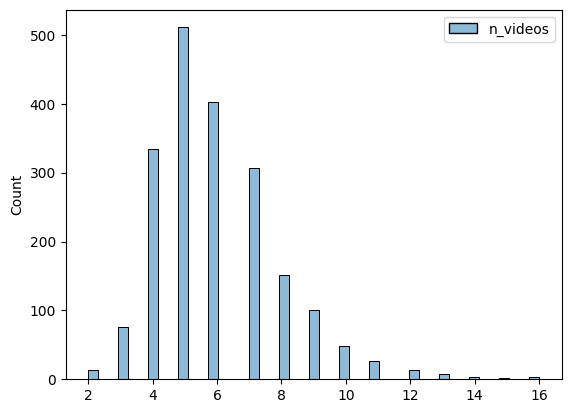

In [28]:
sns.histplot(videos_per_gloss_df);


### Dataframe for videos

## Video to landmarks (mediapipe)

https://www.kaggle.com/code/minnikeswarrao/video-to-mediapipe-parquet

In [29]:
def transform(path , start_frame , end_frame , fps):
    frame_number = 0
    frame = []
    type_ = []
    index = []
    x = []
    y = []
    z = []
    
    cap = cv2.VideoCapture(path)
    cap.set(cv2.CAP_PROP_FPS, fps)
    with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break
            frame_number += 1
            if frame_number < start_frame:
                continue
            if end_frame != -1 and frame_number > end_frame:
                break
            image.flags.writeable = False
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = holistic.process(image)
            #face
            if(results.face_landmarks is None):
                for i in range(478):
                    frame.append(frame_number)
                    type_.append("face")
                    index.append(ind)
                    x.append(0)
                    y.append(0)
                    z.append(0)
            else:
                for ind,val in enumerate(results.face_landmarks.landmark):
                    frame.append(frame_number)
                    type_.append("face")
                    index.append(ind)
                    x.append(val.x)
                    y.append(val.y)
                    z.append(val.z)
            #pose
            if(results.pose_landmarks is None):
                for i in range(32):
                    frame.append(frame_number)
                    type_.append("pose")
                    index.append(ind)
                    x.append(0)
                    y.append(0)
                    z.append(0)
            else:
                for ind,val in enumerate(results.pose_landmarks.landmark):
                    frame.append(frame_number)
                    type_.append("pose")
                    index.append(ind)
                    x.append(val.x)
                    y.append(val.y)
                    z.append(val.z)
            #left hand
            if(results.left_hand_landmarks is None):
                for i in range(20):
                    frame.append(frame_number)
                    type_.append("left_hand")
                    index.append(ind)
                    x.append(0)
                    y.append(0)
                    z.append(0)
            else:
                for ind,val in enumerate(results.left_hand_landmarks.landmark):
                    frame.append(frame_number)
                    type_.append("left_hand")
                    index.append(ind)
                    x.append(val.x)
                    y.append(val.y)
                    z.append(val.z)
            #right hand
            if(results.right_hand_landmarks is None):
                for i in range(20):
                    frame.append(frame_number)
                    type_.append("right_hand")
                    index.append(ind)
                    x.append(0)
                    y.append(0)
                    z.append(0)
            else:
                for ind,val in enumerate(results.right_hand_landmarks.landmark):
                    frame.append(frame_number)
                    type_.append("right_hand")
                    index.append(ind)
                    x.append(val.x)
                    y.append(val.y)
                    z.append(val.z)
            
    return pd.DataFrame({
        "frame" : frame,
        "type"  : type_,
        "landmark_index" : index,
        "x" : x,
        "y" : y,
        "z" : z
    })

In [30]:
word = 'hello'
word_mask = videos_df['gloss'] == word

video = videos_df[word_mask].iloc[0]

video_id = video.video_id
video_file = video_id + '.mp4'
video_path = os.path.join(WLASL_VIDEO_DIR, video_file)

Video(url=video_path, width=400)

In [31]:
start_frame = video.frame_start
end_frame = video.frame_end
fps = video.fps
sign = transform(video_path , start_frame , end_frame , fps)
sign.y = - 1 * sign.y

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [32]:
sign

,frame,type,landmark_index,x,y,z
0,1,face,0,0.502173,-0.350362,-0.011106
1,1,face,1,0.502217,-0.326035,-0.020047
2,1,face,2,0.501977,-0.333661,-0.010450
3,1,face,3,0.498808,-0.302896,-0.014954
4,1,face,4,0.502213,-0.318750,-0.021292
...,...,...,...,...,...,...
49809,92,right_hand,32,0.000000,-0.000000,0.000000
49810,92,right_hand,32,0.000000,-0.000000,0.000000
49811,92,right_hand,32,0.000000,-0.000000,0.000000
49812,92,right_hand,32,0.000000,-0.000000,0.000000


In [33]:
sign[(sign.type=='right_hand') & (sign.x>0)]

,frame,type,landmark_index,x,y,z
16751,31,right_hand,0,0.358445,-0.926320,1.955940e-08
16752,31,right_hand,1,0.375054,-0.929763,-6.767998e-03
16753,31,right_hand,2,0.391133,-0.948650,-1.266609e-02
16754,31,right_hand,3,0.400048,-0.968649,-1.752313e-02
16755,31,right_hand,4,0.403993,-0.988845,-2.199413e-02
...,...,...,...,...,...,...
35193,65,right_hand,16,0.396245,-1.071696,-8.527956e-03
35194,65,right_hand,17,0.381215,-0.979583,-1.150445e-02
35195,65,right_hand,18,0.383298,-1.020834,-1.083946e-02
35196,65,right_hand,19,0.382250,-1.042363,-7.960084e-03


In [34]:
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# def animation_frame(f):
#     frame = sign[sign.frame==f]
#     left = frame[frame.type=='left_hand']
#     right = frame[frame.type=='right_hand']
#     pose = frame[frame.type=='pose']
#     face = frame[frame.type=='face'][['x', 'y']].values
#     lx, ly = get_hand_points(left)
#     rx, ry = get_hand_points(right)
#     px, py = get_pose_points(pose)
#     ax.clear()
#     ax.plot(face[:,0], face[:,1], '.')
#     for i in range(len(lx)):
#         ax.plot(lx[i], ly[i])
#     for i in range(len(rx)):
#         ax.plot(rx[i], ry[i])
#     for i in range(len(px)):
#         ax.plot(px[i], py[i])
#     plt.xlim(xmin, xmax)
#     plt.ylim(ymin, ymax)
        
# ## These values set the limits on the graph to stabilize the video
# xmin = sign.x.min() - 0.2
# xmax = sign.x.max() + 0.2
# ymin = sign.y.min() - 0.2
# ymax = sign.y.max() + 0.2

# fig, ax = plt.subplots(1)
# l, = ax.plot([], [])
    
# animation = FuncAnimation(fig, func=animation_frame, frames=range(40,45)) # doees not work when hand not detected

# HTML(animation.to_html5_video())